# Giskard case study solution by Juan Lopez 🐢

## Instructions for the reader:

⭐️ Hello! welcome to my solution for this case study for the Data Science intern position at Giskard. The main objective is to achieve a higher accuracy than the base model using *ONLY* data agumentation techniques!

⭐️ Please make sure to read the paragraphs, especially the ones with emojis such as this star. In those lines I will be commenting about important details or results that will let you understand my thoughs process with a lot of detail.

## Introduction and main workflow





⭐️ Our main objective is to create syntetic data samples that make us have a more robust and general model, in order to do that we have to make sure that the data we are creating is meaningful and without overfitting the model just to achieve a higher precision. We want to focus our attention on sub-sets of the dataset that are underperformed by our model.

⭐️ For this project I would like to propose some techniques that involve creating syntetic samples according to these subsets of the TRAINING DATA. Each time we will focus on more specific parts of the datasets so we can improve the accuracy of the base model.

## 1. Imports and loading data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# We run this to bypass some annoying warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#... import sklearn stuff...
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn import over_sampling



url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python")
# Declare the type of each column in the dataset(example: category, numeric, text)

column_types = {'default':"category",
               'account_check_status':"category",
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

print('INFO: imports and data ready!!!')

INFO: imports and data ready!!!


# 2. Base model
Below you will find the model we have to beat; It consist on a standard preprocessing pipeline follwed by a LogisticRegression, which achieves an accuracy of 75.5%

In [3]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)) ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
      ('cat', categorical_transformer, columns_to_encode)
          ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

# Split the data into train and test
Y=credit['default']
X= credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)



clf_logistic_regression.fit(X_train, Y_train)
print('--------------------------------')
print(f"Accuracy in the tests set we have to beat: {clf_logistic_regression.score(X_test, Y_test)}")
print('--------------------------------')

print(f"⭐️⭐️⭐️⭐️⭐️ HOWEVER... Accuracy in the training set: {clf_logistic_regression.score(X_train, Y_train)} THIS IS KEY ⭐️⭐️⭐️⭐️⭐️")


--------------------------------
Accuracy in the tests set we have to beat: 0.755
--------------------------------
⭐️⭐️⭐️⭐️⭐️ HOWEVER... Accuracy in the training set: 0.79 THIS IS KEY ⭐️⭐️⭐️⭐️⭐️


### 🔸 HOWEVER...
The fact that the performance of the algorithm has low variance tells us that a hint that the algorithm underperforms on "certain kind" of data. Let's filter out samples that make the model underperform in both training an test set

## 3. Problematic samples

We are going draw out of the testing set those samples that being missclassified, aka: "problematic samples". We can easily do this by using mask filtering.

In [4]:
# This mask contais a True if the sample was not predicted correctly by the base model
incorrect_mask_test = Y_test != clf_logistic_regression.predict(X_test)
# These are all the samples from the test set that are hard to classify, therefor we want to generate syntetic samples similar to those
X_underperform_test = X_test[incorrect_mask_test]
Y_underperform_test = Y_test[incorrect_mask_test]

print("Let's see the class balance of the problematic samples in the test set:")
print(Y_underperform_test.value_counts())
print("⭐️ As you can see, the classe are fairly balanced, this information is actually important,\n because it tells us that the model might not underperforming because of class imbalance! Therefore, creating syntetic\n data by just undersampling the minority class probably wont help")

# This mask contais a True if the sample was not predicted correctly by the base model
incorrect_mask_train = Y_train != clf_logistic_regression.predict(X_train)
# These are all the samples from the test set that are hard to classify, therefor we want to generate syntetic samples similar to those
X_underperform_train = X_train[incorrect_mask_train]
Y_underperform_train = Y_train[incorrect_mask_train]

print("Let's see the class balance of the problematic samples in the training set:")
print(Y_underperform_train.value_counts())
print("⭐️ In this case the classes of the underperforming samples are unbalanced.\n Since in this case the class balance is different than in the test set,\n tells us another hint that the class balance isn't the problem")

Let's see the class balance of the problematic samples in the test set:
Default        28
Not default    21
Name: default, dtype: int64
⭐️ As you can see, the classe are fairly balanced, this information is actually important,
 because it tells us that the model might not underperforming because of class imbalance! Therefore, creating syntetic
 data by just undersampling the minority class probably wont help
Let's see the class balance of the problematic samples in the training set:
Default        114
Not default     54
Name: default, dtype: int64
⭐️ In this case the classes of the underperforming samples are unbalanced.
 Since in this case the class balance is different than in the test set,
 tells us another hint that the class balance isn't the problem


### 🚩🚩🚩REALLY IMPORTANT NOTE🚩🚩🚩 
### To prevent data leakage and other problems we must only use the direct augmenting techniques from in the training set (after spliting the data). The metrics of the model will be overoptimistic if we build the model using information that would not be available at prediction time. This WILL decrease the performance of the model in real life applications.

### Creating syntetic samples
⭐️ For this project, we will use SMONTENC, which is used to balance out classes by creating synthetic samples similar to the ones seen on each class. This algorithm uses the k_neighbors to take into account to create each sample. The reason we are using this method for creating the synthetic samples is because it supports mixed data types. With this method, we are going to move forward into implementing resampling techniques of more specific parts of the dataset.

## 4. SMOTENC to try to fight the unbalance of classes
In the next section we are just going to balance out the classes to see that indeed the performance of the model is not a matter of class balance

In [5]:


# We create a mask to tell the SMOTENC algorithm which are our categorical variables
categorical_mask = [column_types[column]=='category' for column in X_train.columns]

sm = over_sampling.SMOTENC(categorical_features=categorical_mask,
                      sampling_strategy='minority', # We decide the number of samples for each class
                      random_state=30,
                      k_neighbors=20 # Number of nearest neighbors to take into consideration for the sampling strategy
                      )


# Let's resample the training dataset
X_res, Y_res = sm.fit_resample(X_train, Y_train)

print(f'Shape of training set before resampling:\n X_train shape:{X_train.shape}\n X_res shape:{X_res.shape}')
print(f'Shape of training set after resampling:\n Y_train shape:{Y_train.shape}\n X_res shape:{Y_res.shape}')


# Lets train and test the model
clf_logistic_regression.fit(X_res, Y_res)
print(f"Accuracy after simple SMOTENC: {clf_logistic_regression.score(X_test, Y_test)}%")

print("Value counts for each class")
print(Y_res.value_counts())



Shape of training set before resampling:
 X_train shape:(800, 21)
 X_res shape:(1120, 21)
Shape of training set after resampling:
 Y_train shape:(800,)
 X_res shape:(1120,)
Accuracy after simple SMOTENC: 0.73%
Value counts for each class
Not default    560
Default        560
Name: default, dtype: int64


### ⭐️ As you can see, we found that the main problem is not related to the imbalance of classes. No matter how many syntetic samples you create for each class by hand, the performance of the model won't be higher

## Basic SMOTENC resampling from underperforming samples from the training set
 We are going to wrap up the SMOTENC algorithm so instead of resampling a given dataset to deal wth class imbalance it will give us a determined number of syntetic samples for each class (Default and Not default) that we want! We can do that because the SMOTENC method concatenates the new samples to the botton of the original dataset, we can retrieve the syntetic ones by just slicing them out!

With this, we have a function that will create n_default+n_not_default syntetic samples by using any dataset slice that we want. Take a look at the next fucntion

In [6]:
def SMOTENC_datagen(X, Y, n_default, n_not_default, k_neighbors):

    # X: features
    # Y: targets
    # n_default: number of desired syntetic samples of the "Default" class
    # n_not_default: number of desired syntetic samples of the "Not default" class
    # k_neighbors: number of neighbors of the same class to be considered for the creation of a new sample

    n_def, n_not_def = Y.value_counts()
    max_row = Y.shape[0]
    categorical_mask = [column_types[column]=='category' for column in X_train.columns]

    sm = over_sampling.SMOTENC(categorical_features=categorical_mask,
                      sampling_strategy={'Default': n_def + n_default,
                                        'Not default': n_not_def + n_not_default
                                         }, # Here we selest the number of samples generated for each target
                      random_state=30,
                      k_neighbors=k_neighbors # Number of nearest neighbors to take into consideration for the sampling strategy
                      )
    X__resampled, Y_resampled = sm.fit_resample(X, Y)

    return X__resampled[max_row:], Y_resampled[max_row:]
    

We are going to use the function we just define to add some new data for the training set, but rember, we are generating syntetic samples from those underperforming samples in the training set!

In [7]:


X_syn, Y_syn = SMOTENC_datagen(X_underperform_train, Y_underperform_train, 50, 50, k_neighbors=7)


# We concatenate the training set with the new syntetic samples
X_aug = pd.concat([X_train, X_syn], axis=0)
Y_aug = pd.concat([Y_train, Y_syn], axis=0)


print(f'Shape of training set before resampling:\n X_trainshape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'Shape of training set after resampling:\n X_aug shape: {X_aug.shape}, Y_aug shape: {Y_aug.shape}')

# Lets train and test the on the new set
clf_logistic_regression.fit(X_aug, Y_aug)

print(f"Accuracy after SMOTENC: {clf_logistic_regression.score(X_test, Y_test)}")

Shape of training set before resampling:
 X_trainshape: (800, 21), Y_train shape: (800,)
Shape of training set after resampling:
 X_aug shape: (900, 21), Y_aug shape: (900,)
Accuracy after SMOTENC: 0.78


### 🟢 Using this simple method we already beat the base model by getting an accuracy of 78%

# Auto-tunning of the hyper parameters of the SMOTENC

Since we have the freedom to select the number of samples genereated for each class, and the k_neighbors parameter, It means that we have to do some hyper-parameter tuning tunning for our SMOTENC_datagen function. Therefore, we will give the a the freedom to an dummy_minimize algorithm to choose the hyperparameters from a hyper-parameter space via a grid search. This will ajust for us the amount of new syntetic problematic samples to be created for each class, and also the amount of neightbors considered to create the new samples.

### 🚩🚩🚩REALLY IMPORTANT NOTE🚩🚩🚩 
In a real life escenario, the best practice would be sampling the hyper-parameter space of the SMOTENC_datagen to maximize the performance of the logistic_regression model in a VALIDATION SET and not in the TRAINING SET. 

Here, for sake of simplicity, and because we dont really have a lot of data, we are going sample the parameters that maximize the performance on the TEST set because I believe that doing another train-validation split of 200 or 100 samples will reduce drastically the amount of data and most likely will deprive us of having really interesting data groups of outliers in every dataset.



In [14]:
from skopt.space import Integer
from skopt import dummy_minimize, gbrt_minimize


space  = [
          Integer(0, 80, name='n_default'),
          Integer(0, 80, name='n_not_default'),
          Integer(5, 8, name='k_neighbors')]



def objective(params):

    n_default, n_not_default, k_neighbors = params

    X_syn, Y_syn = SMOTENC_datagen(X_underperform_train, Y_underperform_train, n_default=n_default, n_not_default=n_not_default, k_neighbors=k_neighbors)

    X_aug = pd.concat([X_train, X_syn], axis=0)
    Y_aug = pd.concat([Y_train, Y_syn], axis=0)

    clf_logistic_regression.fit(X_aug, Y_aug)
    
    return -clf_logistic_regression.score(X_test, Y_test)


res_gp = gbrt_minimize(objective, space, n_calls=200, random_state=30, verbose=False, initial_point_generator='random')
print('Optimization finished')

print(f'Best accuracy score: {-res_gp.fun}')
print(f'Beest parameters found: n_default={res_gp.x[0]}, n_non_default={res_gp.x[1]}, k_neighbors={res_gp.x[2]}')




Optimization finished
Best accuracy score: 0.81
Beest parameters found: n_default=14, n_non_default=58, k_neighbors=7


### 🔸 81% Accuracy, not bad!
### 🔸 We already beat the base stimator, but what happens if we also use both the problematic samples from the training set AND test set to generate our syntetic data?

### 🚩Disclaimer🚩 We are not going to use any of the samples of the testing set to train the model, but to use their information to create syntetic data similar to them. I believe the safest practice is the one above, but this one is also interesting because is equivalent of using Giskard 🐢 to inspect the test set to extract useful knowledge to improve our model, as it is done in this example: https://github.com/Giskard-AI/giskard-examples/blob/main/Credit%20scoring%20classification%20model.ipynb



In [31]:
space  = [
          Integer(20, 100, name='n_default'),
          Integer(20, 60, name='n_not_default'),
          Integer(4, 8, name='k_neighbors')]

def objective(params):

    n_default, n_not_default, k_neighbors = params

    X_syn, Y_syn = SMOTENC_datagen(
        pd.concat([X_underperform_train, X_underperform_test], axis=0), 
        pd.concat([Y_underperform_train, Y_underperform_test], axis=0),
        n_default=n_default, n_not_default=n_not_default, k_neighbors=k_neighbors)

    X_aug = pd.concat([X_train, X_syn], axis=0)
    Y_aug = pd.concat([Y_train, Y_syn], axis=0)

    clf_logistic_regression.fit(X_aug, Y_aug)
    
    return -clf_logistic_regression.score(X_test, Y_test)


res_gp = gbrt_minimize(objective, space, n_calls=200)
print('Optimization finished')

print(f'Best accuracy score: {-res_gp.fun}')
print(f'Beest parameters found: n_default={res_gp.x[0]}, n_non_default={res_gp.x[1]}, k_neighbors={res_gp.x[2]}')



Optimization finished
Best accuracy score: 0.815
Beest parameters found: n_default=25, n_non_default=48, k_neighbors=7


### As you can see, the accuracy is slightly higher

## Using k-prototypes to create to identify groups on the underperfoming part of the training set
We want to identify sub-sets of similar samples within the underperfoming training set. Then we want to sample each sub set individualy to have more control on what "kind" of sample are we creating. The reason why I wanted to use a cluster algorithm is beacause it lets us find abstract groups of samples that we might not find by just filtering by columns in the underperfoming training dataset.

### Elbow technique
Let's find the optimal number of clusters to separate the underperforming part of the training data

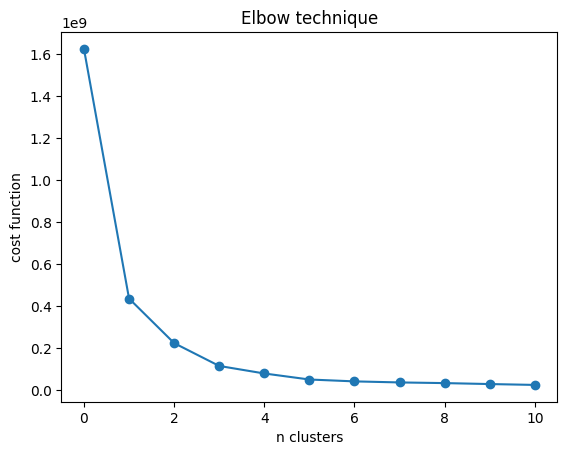

In [16]:
from kmodes.kprototypes import KPrototypes


categorical_mask = [column_types[column]=='category' for column in X_train.columns]
# We need to tell the algorithm the index positions of the categorical variables, we can easily do this with the next line
categorical_positions = [index for index, value in enumerate(categorical_mask) if value ==True]

# Elbow technique

cost = []
for cluster in range(1, 12):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 30)
    kprototype.fit_predict(X_underperform_train.to_numpy(), categorical = categorical_positions)
    cost.append(kprototype.cost_)


plt.figure()
plt.title('Elbow technique')
plt.xlabel('n clusters')
plt.ylabel('cost function')
plt.plot(cost, '-o')
plt.show()

## We can see that the optimal amount of clusters is 4 or 5. Let's do 4

In [17]:

kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 30)
cluster_labels = kprototype.fit_predict(X_underperform_train.to_numpy(), categorical = categorical_positions)

### Now we are going to separate the X_underperform in their 4 differet parts according to the clusters

In [22]:
mask_0 = cluster_labels == 0
X_0 = X_underperform_train[mask_0]
Y_0 = Y_underperform_train[mask_0]

mask_1 = cluster_labels == 1
X_1 = X_underperform_train[mask_1]
Y_1 = Y_underperform_train[mask_1]

mask_2 = cluster_labels == 2
X_2 = X_underperform_train[mask_2]
Y_2 = Y_underperform_train[mask_2]

mask_3 = cluster_labels == 3
X_3 = X_underperform_train[mask_3]
Y_3 = Y_underperform_train[mask_3]


## Now, we just let's let the model optimize the nuber of samples created for each cluster and hope for better results than before!

In [37]:
space=[
       Integer(0, 15, name='n_default_0'),
       Integer(0, 15, name='n_not_default_0'),
       Integer(3, 4, name='k_0'),

       Integer(0, 15, name='n_default_1'),
       Integer(0, 15, name='n_not_default_1'),
       Integer(3, 7, name='k_1'),

       Integer(0, 15, name='n_default_2'),
       Integer(0, 15, name='n_not_default_2'),
       Integer(3, 7, name='k_2'),
       
       Integer(0, 5, name='n_default_3'),
       Integer(0, 5, name='n_not_default_3'),
       Integer(3, 7, name='k_3')
       ]



def objective(params):

    n_default_0, n_not_default_0, k_0, n_default_1, n_not_default_1, k_1, n_default_2, n_not_default_2, k_2, n_default_3, n_not_default_3, k_3 = params

    X_syn_0, Y_syn_0 = SMOTENC_datagen(X_0, Y_0, n_default=n_default_0, n_not_default=n_not_default_0, k_neighbors=k_0)
    X_syn_1, Y_syn_1 = SMOTENC_datagen(X_1, Y_1, n_default=n_default_1, n_not_default=n_not_default_1, k_neighbors=k_1)
    X_syn_2, Y_syn_2 = SMOTENC_datagen(X_2, Y_2, n_default=n_default_2, n_not_default=n_not_default_2, k_neighbors=k_2)
    X_syn_3, Y_syn_3 = SMOTENC_datagen(X_3, Y_3, n_default=n_default_3, n_not_default=n_not_default_3, k_neighbors=k_3)

    X_aug = pd.concat([X_train,
                       X_syn_0,
                       X_syn_1,
                       X_syn_2,
                       X_syn_3
                       ], axis=0)

    Y_aug = pd.concat([Y_train,
                       Y_syn_0,
                       Y_syn_1,
                       Y_syn_2,
                       Y_syn_3
                       ], axis=0)

    clf_logistic_regression.fit(X_aug, Y_aug)
    
    return -clf_logistic_regression.score(X_test, Y_test)


res_gp = gbrt_minimize(objective, space, n_calls=2000, random_state=30, verbose=False, initial_point_generator='random')
print('Optimization finished')

print(f'Best accuracy score: {-res_gp.fun}')
print(f'Beest parameters found: n_default={res_gp.x[0]}, n_non_default={res_gp.x[1]}, k_neighbors={res_gp.x[2]}')


Optimization finished
Best accuracy score: 0.83
Beest parameters found: n_default=10, n_non_default=12, k_neighbors=4


## 🟢 As you can see, just as expected, this technique had better accuracy than the previous methods (83% this time), and is not touching the the information of the test set at all!

## Preliminary things to do before Giskard

In [ ]:

train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test ], axis=1)

# Testing Giskard
Let's use Giskard to explore the model and the dataset

In [ ]:
from giskard import GiskardClient
url = "http://localhost:19000" #if Giskard is installed locally (for installation, see: https://docs.giskard.ai/start/guides/installation)
token = "giskard_case_study" #you can generate your API token in the Admin tab of the Giskard application (for installation, see: https://docs.giskard.ai/start/guides/installation)

client = GiskardClient(url, token)

# your_project = client.create_project("project_key", "PROJECT_NAME", "DESCRIPTION")
# Choose the arguments you want. But "project_key" should be unique and in lower case
credit_scoring = client.create_project("credit_scoring", "German Credit Scoring", "Project to predict if user will default")

# If you've already created a project with the key "credit-scoring" use
#credit_scoring = client.get_project("credit_scoring")f

In [ ]:
credit_scoring.upload_model_and_df(
    prediction_function=clf_logistic_regression.predict_proba, # Python function which takes pandas dataframe as input and returns probabilities for classification model OR returns predictions for regression model
    model_type='classification', # "classification" for classification model OR "regression" for regression model
    df=test_data, # the dataset you want to use to inspect your model
    column_types=column_types, # A dictionary with columns names of df as key and types(category, numeric, text) of columns as values
    target='default', # The column name in df corresponding to the actual target variable (ground truth).
    feature_names=list(feature_types.keys()), # List of the feature names of prediction_function
    classification_labels=clf_logistic_regression.classes_ ,  # List of the classification labels of your prediction
    model_name='logistic_regression_v1', # Name of the model
    dataset_name='test_data' # Name of the dataset
)

/Users/juansmacbookair/Desktop/giskard/.venv/lib/python3.9/site-packages/giskard/client/project.py:664: UserWarning: Feature 'people_under_maintenance' is declared as 'numeric' but has 2 (<= nuniques_category=2) distinct values. Are you sure it is not a 'category' feature?
  warning(


Dataset successfully uploaded to project key 'credit_scoring' with ID = 27. It is available at http://localhost:19000 
Model successfully uploaded to project key 'credit_scoring' with ID = 28. It is available at http://localhost:19000 


(28, 27)